In [1]:
import numpy as np
import pandas as pd

from src.data_download import get_data_from_tradingview

constituents = pd.read_excel(
    '../data/SP100_constituent.xlsx'
)

In [2]:
from tvDatafeed import Interval, TvDatafeed

prices = get_data_from_tradingview(
    tickers = constituents['Symbol'].tolist(),
    exchange = constituents['Exchange'].tolist(),
    interval = Interval.in_daily,
    n_bars = 13000,
    column = 'close',
    verbose = True,
    num_trials = 100
)

you are using nologin method, data you access may be limited
34it [02:54,  5.91s/it]ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
64it [05:32,  6.78s/it]ERROR:tvDatafeed.main:Connection timed out
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
67it [06:09,  9.52s/it]ERROR:tvDatafeed.main:Connection timed out
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
77it [07:10,  3.59s/it]ERROR:tvDatafeed.main:Connection to remote host was lost.
ERROR:tvDatafeed.main:no data, please check the exchange and symbol
100it [08:47,  5.27s/it]


### Fractional Diffrentiation

In [4]:
from statsmodels.tsa.stattools import adfuller
from joblib import Parallel, delayed

def get_weights_ffd(d, thres, size):
    w = [1.0]
    for k in range(1, size):
        w_ = -w[-1] * (d - k + 1) / k
        if abs(w_) < thres:
            break
        w.append(w_)
    return np.array(w[::-1]).reshape(-1, 1)

def frac_diff_ffd(series, d, thres = 1e-4):
    series = series.dropna()
    w = get_weights_ffd(d, thres, len(series))
    width = len(w) - 1

    series_f = series.ffill().dropna()
    res = []
    for i in range(width, series_f.shape[0]):
        res.append(np.dot(w.T, series_f.iloc[i-width:i+1])[0])

    return pd.Series(res, index=series_f.index[width:])

def find_optimal_d_and_diff(series, name):
    for d in np.linspace(0, 1, 21):
        diff_series = frac_diff_ffd(series, d)
        if diff_series.empty: continue

        p_val = adfuller(diff_series, maxlag=1, regression='c', autolag=None)[1]
        if p_val < 0.05:
            return name, d, diff_series

    return name, 1.0, frac_diff_ffd(series, 1.0)

def parallel_frac_diff(df, n_jobs=-1) -> tuple:
    print(f"Starting parallel FracDiff on {len(df.columns)} assets...")

    results = Parallel(n_jobs=n_jobs)(
        delayed(find_optimal_d_and_diff)(df[col], col) for col in df.columns
    )
    d_stats = {}
    diff_dfs = []

    for name, d, series in results:
        d_stats[name] = round(float(d),2)
        diff_dfs.append(series)

    final_df = pd.concat(diff_dfs, axis=1)
    final_df.columns = df.columns # rename columns

    return final_df, d_stats

def get_representative_d(df, quantile=0.9, n_jobs=-1):
    """
    Step 1: Find the minimum required 'd' for each column to achieve stationarity.
    Step 2: Select a representative 'd' based on the given quantile.
    """
    def find_min_d(series):
        # Scan 'd' from 0 to 1 with 0.05 step
        for d in np.linspace(0, 1, 21):
            diff_series = frac_diff_ffd(series, d)
            if diff_series.empty: continue

            # Use maxlag=1 for consistency in p-value testing
            p_val = adfuller(diff_series, maxlag=1, regression='c', autolag=None)[1]
            if p_val < 0.05:
                return d
        return 1.0

    print(f"🔍 Searching for minimum stationarity 'd' per asset...")
    individual_ds = Parallel(n_jobs=n_jobs)(
        delayed(find_min_d)(df[col]) for col in df.columns
    )

    # Select representative d (e.g., 90th percentile to ensure most assets are stationary)
    rep_d = np.percentile(individual_ds, quantile * 100)
    print(f"🎯 Representative d selected: {rep_d:.2f} (Quantile: {quantile})")

    return rep_d, individual_ds

def apply_uniform_frac_diff(df, d_value, n_jobs=-1):
    """
    Apply a single 'd' value to all columns in the DataFrame.
    """
    print(f"🚀 Applying uniform FracDiff (d={d_value:.2f}) to all columns...")

    results = Parallel(n_jobs=n_jobs)(
        delayed(frac_diff_ffd)(df[col], d_value) for col in df.columns
    )

    final_df = pd.concat(results, axis=1)
    final_df.columns = df.columns
    return final_df

In [5]:
representative_d, all_ds = get_representative_d(np.log(prices), quantile=0.95)

🔍 Searching for minimum stationarity 'd' per asset...
🎯 Representative d selected: 0.30 (Quantile: 0.95)


In [6]:
fracdiff_price = apply_uniform_frac_diff(np.log(prices), representative_d, n_jobs = -2)

🚀 Applying uniform FracDiff (d=0.30) to all columns...


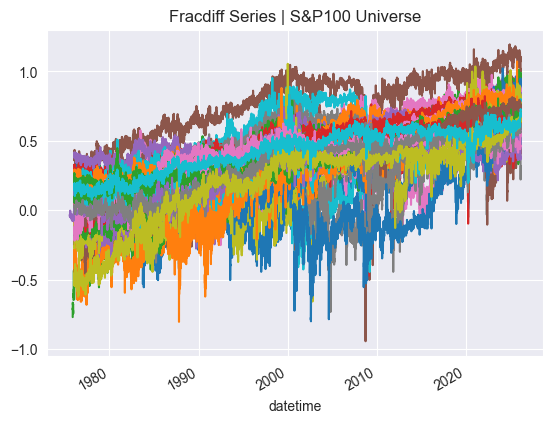

In [7]:
import matplotlib.pyplot as plt

fracdiff_price.plot(legend = False)
plt.title('Fracdiff Series | S&P100 Universe')
plt.show()

### Calculating Mutual Information (distance)

In [9]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import KBinsDiscretizer

import itertools

def calculate_mutual_info_pair(
        data : pd.DataFrame,
        asset_i : str,
        asset_j : str
    ) -> tuple :
    "calculate mutual information between asset i and asset j"
    x = data.iloc[:, asset_i].values.reshape(-1, 1)
    y = data.iloc[:, asset_j].values

    mutual_information = mutual_info_regression(
        x, y,
        n_neighbors = 3,
        random_state = 42
    )[0]
    return asset_i, asset_j, mutual_information

In [10]:
def get_mutual_info_matrix(
        data : pd.DataFrame,
        n_jobs : int = -1
    ) -> pd.DataFrame :
    n_assets = data.shape[1]
    asset_names = data.columns

    print(f"Calculating MI for {n_assets} assets ({n_assets*(n_assets-1)//2} pairs)...")

    pairs = list(itertools.combinations(range(n_assets), 2))

    results = Parallel(n_jobs=n_jobs)(
        delayed(calculate_mutual_info_pair)(data, i, j) for i, j in pairs
    )

    mi_matrix = np.zeros((n_assets, n_assets))

    for i, j, mi in results:
        mi_matrix[i, j] = mi
        mi_matrix[j, i] = mi

    for i in range(n_assets):
        mi_matrix[i, i] = mutual_info_regression(
            data.iloc[:, i].values.reshape(-1, 1),
            data.iloc[:, i].values,
            n_neighbors=3, random_state=42
        )[0]

    dist_matrix = np.zeros((n_assets, n_assets))
    for i, j in itertools.combinations(range(n_assets), 2):
        h_x = mi_matrix[i, i]
        h_y = mi_matrix[j, j]
        mi_xy = mi_matrix[i, j]

        nmi = mi_xy / max(h_x, h_y, 1e-10)
        distance = max(0, 1 - nmi)

        dist_matrix[i, j] = distance
        dist_matrix[j, i] = distance

    return pd.DataFrame(dist_matrix, index=asset_names, columns=asset_names)

In [11]:
import warnings

from sklearn.metrics import mutual_info_score
from tqdm import tqdm

warnings.filterwarnings('ignore')

def calculate_discrete_mi_matrix(df, bins=10):
    n_assets = df.shape[1]

    kbd = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='quantile')
    df_discrete = pd.DataFrame(kbd.fit_transform(df), columns=df.columns)

    h_list = []
    for i in range(n_assets):
        h = mutual_info_score(df_discrete.iloc[:, i], df_discrete.iloc[:, i])
        h_list.append(h)

    dist_matrix = np.zeros((n_assets, n_assets))
    for i in tqdm(range(n_assets)):
        for j in range(i + 1, n_assets):
            mi = mutual_info_score(df_discrete.iloc[:, i], df_discrete.iloc[:, j])

            nmi = mi / max(h_list[i], h_list[j])

            distance = max(0, 1 - nmi)

            dist_matrix[i, j] = distance
            dist_matrix[j, i] = distance

    return pd.DataFrame(dist_matrix, index=df.columns, columns=df.columns)

In [12]:
test_mi = calculate_discrete_mi_matrix(
    fracdiff_price.loc['2016':].dropna(axis = 1),
    bins = 10
)

100%|██████████| 97/97 [00:02<00:00, 35.04it/s]


In [13]:
test_mi

,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,TXN,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
AAPL,0.000000,0.800929,0.773625,0.741959,0.783744,0.924516,0.716099,0.854543,0.908189,0.752831,...,0.778977,0.782870,0.799997,0.900205,0.945549,0.712896,0.941381,0.908439,0.733324,0.889844
ABBV,0.800929,0.000000,0.858315,0.860813,0.893079,0.911299,0.868942,0.837839,0.943921,0.875299,...,0.870902,0.828849,0.880860,0.926769,0.969421,0.816705,0.935088,0.909461,0.816696,0.885681
ABT,0.773625,0.858315,0.000000,0.763168,0.814972,0.937300,0.802466,0.870240,0.863007,0.792326,...,0.807939,0.847424,0.787044,0.910648,0.974498,0.721513,0.965618,0.943154,0.791718,0.939807
ACN,0.741959,0.860813,0.763168,0.000000,0.756168,0.942979,0.794515,0.901264,0.899851,0.814415,...,0.768485,0.801509,0.758030,0.901595,0.959663,0.734624,0.969406,0.957436,0.817492,0.933411
ADBE,0.783744,0.893079,0.814972,0.756168,0.000000,0.957698,0.810932,0.918415,0.869924,0.759524,...,0.832766,0.828209,0.825012,0.917474,0.960568,0.756347,0.971852,0.958676,0.829957,0.935759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V,0.712896,0.816705,0.721513,0.734624,0.756347,0.894098,0.763499,0.856973,0.876945,0.745372,...,0.797998,0.820178,0.777008,0.908339,0.968035,0.000000,0.943112,0.886199,0.706515,0.899837
VZ,0.941381,0.935088,0.965618,0.969406,0.971852,0.961412,0.962935,0.979449,0.963792,0.959492,...,0.972442,0.951545,0.977443,0.969162,0.958104,0.943112,0.000000,0.961110,0.938724,0.940501
WFC,0.908439,0.909461,0.943154,0.957436,0.958676,0.829668,0.929009,0.955025,0.974831,0.905403,...,0.945224,0.962209,0.937320,0.956471,0.844442,0.886199,0.961110,0.000000,0.875047,0.876327
WMT,0.733324,0.816696,0.791718,0.817492,0.829957,0.899034,0.815069,0.859327,0.891545,0.775377,...,0.832853,0.842306,0.839008,0.885077,0.942211,0.706515,0.938724,0.875047,0.000000,0.890868


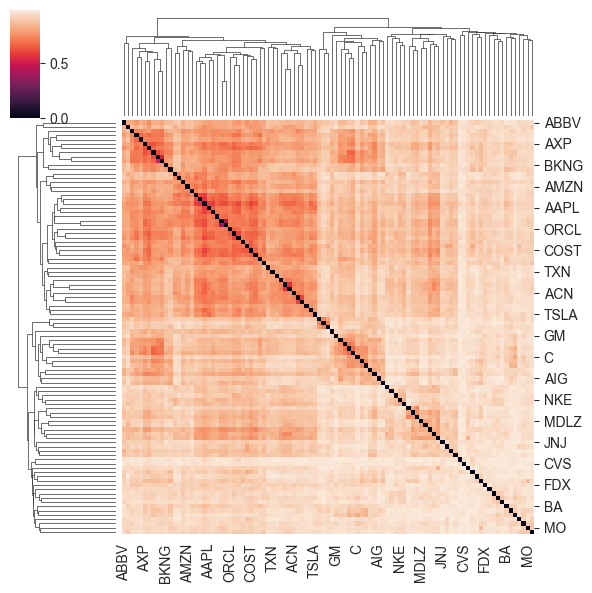

In [14]:
import seaborn as sns

sns.clustermap(test_mi, figsize = (6,6))

### Denoising & Detoning

#### Marcenko - pastur method

In [8]:
from sklearn.neighbors import KernelDensity
from scipy.optimize import minimize
from scipy.linalg import eigh

def get_mp_pdf(
        var : float,
        q : float,
        pts : int
    ) -> pd.Series :
    """
    Generates the theoretical Marchenko-Pastur probability density function.
    """
    e_min = var * (1 - (1./q)**0.5)**2
    e_max = var * (1 + (1./q)**0.5)**2
    e_val = np.linspace(e_min, e_max, pts)
    pdf = q / (2 * np.pi * var * e_val) * ((e_max - e_val) * (e_val - e_min))**0.5
    pdf = pd.Series(pdf.flatten(), index=e_val.flatten())
    return pdf

def fit_kde(
        observations : np.ndarray,
        b_width : float = 0.25 ,
        x_range = None
    ) -> pd.Series :
    """
    Fits a Kernel Density Estimator to the empirical eigenvalues.
    """
    if x_range is None:
        x_range = np.unique(observations).reshape(-1, 1)
    kde = KernelDensity(bandwidth=b_width, kernel='gaussian').fit(observations.reshape(-1, 1))
    log_prob = kde.score_samples(x_range)
    pdf = pd.Series(np.exp(log_prob), index=x_range.flatten())
    return pdf

def err_pdfs(
        var : float,
        observations : np.ndarray,
        q : float, b_width : float,
        pts : int =1000
    ) -> float :
    """
    Calculates the squared error between theoretical and empirical PDFs.
    """
    pdf0 = get_mp_pdf(var, q, pts)
    pdf1 = fit_kde(observations, b_width, x_range=pdf0.index.values.reshape(-1, 1))
    sse = np.sum((pdf0 - pdf1)**2)
    return sse

def denoise_vi_distance_shrinkage(
        vi_dist_df : pd.DataFrame,
        q_ratio : float,
        alpha : float =0.5,
        b_width : float =0.01
    ) -> pd.DataFrame :
    """
    Denoises a VI distance matrix using the MP-Law and Eigenvalue Shrinkage.

    Args:
        vi_dist_df: Linear VI distance matrix (pd.DataFrame).
        q_ratio: T/N ratio.
        alpha: Shrinkage factor (0.0: No change, 1.0: Full flattening to average).
               Set closer to 0.5 to preserve some structure in the noise.
        b_width: KDE bandwidth.
    """
    # Step 1: Convert Distance to Similarity (S = 1 - D)
    similarity_matrix = 1 - vi_dist_df.values

    # Step 2: Eigenvalue Decomposition
    e_val, e_vec = eigh(similarity_matrix)
    indices = e_val.argsort()[::-1]
    e_val, e_vec = e_val[indices], e_vec[:, indices]

    # Step 3: Fit MP distribution to find var (sigma^2)
    # Using the same err_pdfs and get_mp_pdf from previous steps
    out = minimize(lambda *x: err_pdfs(*x), .5, args=(e_val, q_ratio, b_width),
                   bounds=((1e-5, 1-1e-5),))
    var = out.x[0] if out.success else 1.0

    # Step 4: Determine e_max (Threshold)
    e_max = var * (1 + (1./q_ratio)**0.5)**2
    n_facts = e_val[e_val > e_max].shape[0]

    # Logic Check: Ensure we don't accidentally lose all features
    n_facts = max(n_facts, 1)

    print(f"Signal discovered: {n_facts} factors above MP-threshold ({e_max:.4f})")

    # Step 5: Apply Shrinkage to the noise eigenvalues
    # Instead of replacing with a constant, we shrink them towards the average.
    e_val_corr = e_val.copy()
    avg_noise = e_val_corr[n_facts:].mean()

    # Shrinkage formula: (alpha * average) + ((1 - alpha) * original)
    e_val_corr[n_facts:] = alpha * avg_noise + (1 - alpha) * e_val_corr[n_facts:]

    print(f"Noise eigenvalues shrunk towards {avg_noise:.4f} with alpha={alpha}")

    # Step 6: Reconstruct Denoised Similarity Matrix
    denoised_sim = np.dot(e_vec, e_val_corr[:, None] * e_vec.T)

    # Re-scale diagonal to 1
    diag = np.diag(denoised_sim)
    denoised_sim = denoised_sim / np.sqrt(np.outer(diag, diag))

    # Step 7: Convert back to Distance (D = 1 - S)
    denoised_vi_dist = np.clip(1 - denoised_sim, 0, 1)

    print("Shrinkage-based denoising complete.")
    return pd.DataFrame(denoised_vi_dist, index=vi_dist_df.index, columns=vi_dist_df.columns)

In [16]:
def denoise_and_soft_detone_vi_distance(
        vi_dist_df : pd.DataFrame,
        q_ratio : float,
        gamma : float = 0.7,
        alpha : float = 0.5,
        b_width : float =0.01
    ) -> pd.DataFrame :
    """
    Perform spectral denoising and soft-detoning on the VI distance matrix.

    Args:
        vi_dist_df (pd.DataFrame): Linear VI distance matrix.
        q_ratio (float): T/N ratio for Marchenko-Pastur thresholding.
        gamma (float): Detoning strength [0, 1]. 1.0 is hard-detoning.
        alpha (float): Shrinkage intensity for noise eigenvalues.
    """
    # 1. Spectral Decomposition
    S = 1 - vi_dist_df.values
    evals, evecs = np.linalg.eigh(S)
    idx = evals.argsort()[::-1]
    evals, evecs = evals[idx], evecs[:, idx]

    # 2. Denoising (MP-Law with Shrinkage)
    # Optimization to find sigma^2 is assumed to be defined (err_pdfs)
    res = minimize(err_pdfs, [0.5], args=(evals, q_ratio, b_width), bounds=[(1e-5, 1-1e-5)])
    sigma2 = res.x[0] if res.success else 1.0
    e_max = sigma2 * (1 + (1./q_ratio)**0.5)**2

    n_signals = np.sum(evals > e_max)
    avg_noise = evals[n_signals:].mean()
    evals_corr = evals.copy()
    evals_corr[n_signals:] = alpha * avg_noise + (1 - alpha) * evals_corr[n_signals:]

    # 3. Soft Detoning: Scaling the Market Mode (lambda_1)
    # Gamma controls the 'Market Gravity'
    original_lambda1 = evals_corr[0]
    evals_corr[0] = original_lambda1 * (1 - gamma)

    # 4. Reconstruct and Rescale
    # Maintaining the unit diagonal property of the similarity matrix
    S_detoned = evecs @ np.diag(evals_corr) @ evecs.T
    std = np.sqrt(np.diag(S_detoned))
    S_normalized = S_detoned / np.outer(std, std)

    # 5. Inverse Mapping to Distance Space
    D_detoned = np.clip(1 - S_normalized, 0, 1)

    print(f"[*] Gamma {gamma}: Lambda_1 suppressed from {original_lambda1:.3f} to {evals_corr[0]:.3f}")
    return pd.DataFrame(D_detoned, index=vi_dist_df.index, columns=vi_dist_df.columns)

In [17]:
q_ratio = len(fracdiff_price.loc['2016':].dropna(axis = 1)) / len(fracdiff_price.loc['2016':].dropna(axis = 1).columns)

In [18]:
denoise_vi = denoise_and_soft_detone_vi_distance(
    test_mi,
    q_ratio = q_ratio,
)

[*] Gamma 0.7: Lambda_1 suppressed from 13.939 to 4.182


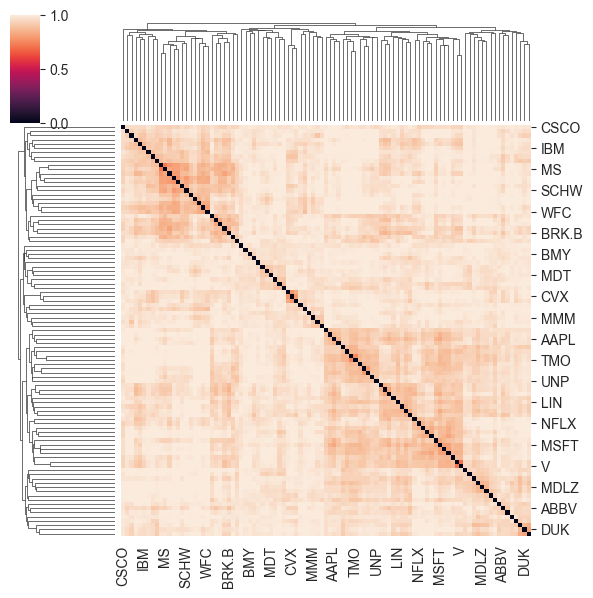

In [19]:
sns.clustermap(denoise_vi, figsize = (6, 6))
plt.show()

#### Another Method (Recommended)

In [15]:
def _as_symmetric(df: pd.DataFrame, tol: float = 1e-12) -> pd.DataFrame:
    """
    Force symmetry by (A + A.T) / 2 to remove numerical asymmetry.
    """
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas.DataFrame.")

    if df.shape[0] != df.shape[1]:
        raise ValueError("Matrix must be square (n x n).")

    if list(df.index) != list(df.columns):
        common = df.index.intersection(df.columns)
        if len(common) != df.shape[0]:
            raise ValueError("Index and columns must contain the same asset labels.")
        df = df.loc[common, common]

    A = df.astype(float)
    A_sym = (A + A.T) / 2.0

    if np.nanmax(np.abs(A_sym.values - A_sym.values.T)) > tol:
        raise ValueError("Failed to symmetrize the matrix within tolerance.")

    return A_sym

def _eigh_sorted(A: np.ndarray):
    """
    Eigen-decomposition for a symmetric matrix with eigenvalues sorted in descending order.
    """
    w, V = np.linalg.eigh(A)
    idx = np.argsort(w)[::-1]
    return w[idx], V[:, idx]


def _nmi_distance_to_similarity(
    dist_df: pd.DataFrame,
    eps: float = 1e-12,
    mode: str = "linear",
) -> pd.DataFrame:
    """
    Convert an NMI-based distance matrix into a similarity matrix.

    Your construction uses:
        nmi = mi / max(H_i, H_j)
        distance = max(0, 1 - nmi)

    Therefore, the natural similarity is:
        similarity = 1 - distance  (clipped to [0, 1])

    Parameters
    ----------
    dist_df : pd.DataFrame
        NMI-based distance matrix (assets x assets), typically in [0, 1].
    eps : float
        Numerical tolerance.
    mode : str
        - "linear": similarity = 1 - distance
        - "exp":    similarity = exp(-distance / scale)

    Returns
    -------
    pd.DataFrame
        Similarity matrix S in [0, 1] with diagonal set to 1.
    """
    D = _as_symmetric(dist_df)
    A = D.values

    if mode == "linear":
        S = 1.0 - A
        S = np.clip(S, 0.0, 1.0)
        np.fill_diagonal(S, 1.0)
        return pd.DataFrame(S, index=D.index, columns=D.columns)

    if mode == "exp":
        off = A[~np.eye(A.shape[0], dtype=bool)]
        scale = np.nanmedian(off)
        scale = float(scale) if np.isfinite(scale) and scale > eps else 1.0
        S = np.exp(-A / scale)
        np.fill_diagonal(S, 1.0)
        return pd.DataFrame(S, index=D.index, columns=D.columns)

    raise ValueError("mode must be one of {'linear', 'exp'}.")


def denoise_lowrank_shrinkage_on_similarity(
    sim_df: pd.DataFrame,
    k: int | None = None,
    energy: float = 0.90,
    alpha: float = 0.50,
    psd_clip: bool = False,
) -> pd.DataFrame:
    """
    Denoise a similarity matrix using low-rank approximation with shrinkage mixing.

    S_denoise = alpha * S_k + (1 - alpha) * S

    Parameters
    ----------
    sim_df : pd.DataFrame
        Similarity matrix (assets x assets), symmetric.
    k : int | None
        Rank of the low-rank approximation. If None, choose k automatically by energy.
    energy : float
        Cumulative explained energy threshold (based on positive eigenvalues).
    alpha : float
        Shrinkage strength.
    psd_clip : bool
        If True, clip negative eigenvalues to zero before reconstructing S_k.

    Returns
    -------
    pd.DataFrame
        Denoised similarity matrix.
    """
    if not (0.0 <= alpha <= 1.0):
        raise ValueError("alpha must be in [0, 1].")
    if not (0.0 < energy <= 1.0):
        raise ValueError("energy must be in (0, 1].")

    S = _as_symmetric(sim_df)
    A = S.values

    w, V = _eigh_sorted(A)

    if psd_clip:
        w = np.maximum(w, 0.0)

    if k is None:
        w_pos = w[w > 0]
        if w_pos.size == 0:
            return S.copy()
        cum = np.cumsum(w_pos) / np.sum(w_pos)
        k = int(np.searchsorted(cum, energy) + 1)
        k = max(1, min(k, A.shape[0]))

    if not (1 <= k <= A.shape[0]):
        raise ValueError(f"k must be between 1 and {A.shape[0]}")

    Vk = V[:, :k]
    wk = w[:k]

    S_k = (Vk * wk) @ Vk.T
    S_denoise = alpha * S_k + (1.0 - alpha) * A

    return pd.DataFrame(S_denoise, index=S.index, columns=S.columns)


def detone_first_eigencomponent(
    sim_df: pd.DataFrame,
    gamma: float = 0.7,
    keep_diagonal: bool = True,
) -> pd.DataFrame:
    """
    Detone a similarity matrix by removing the first eigencomponent (global common mode).

    S_detone = S - lambda1 * v1 v1^T

    Parameters
    ----------
    sim_df : pd.DataFrame
        Symmetric similarity matrix (typically denoised).
    keep_diagonal : bool
        If True, restore the original diagonal after detoning.

    Returns
    -------
    pd.DataFrame
        Detoned similarity matrix.
    """
    S = _as_symmetric(sim_df)
    A = S.values
    diag_before = np.diag(A).copy()

    w, V = _eigh_sorted(A)

    lam1 = w[0]
    v1 = V[:, 0:1]

    A_detone = A - (lam1 * gamma) * (v1 @ v1.T)

    if keep_diagonal:
        np.fill_diagonal(A_detone, diag_before)

    return pd.DataFrame(A_detone, index=S.index, columns=S.columns)


def denoise_and_detone_nmi_distance(
    nmi_distance_df: pd.DataFrame,   # NMI-based distance matrix (assets x assets), values in [0, 1], output of your NMI construction
    similarity_mode: str = "linear", # How to convert distance to similarity: "linear" (S = 1 - D) or "exp" (S = exp(-D / scale))
    k: int | None = None,            # Rank of the low-rank approximation; None selects k automatically based on energy threshold
    energy: float = 0.90,            # Cumulative explained energy threshold used to choose k when k is None
    alpha: float = 0.50,             # Shrinkage strength: S_denoise = alpha * S_lowrank + (1 - alpha) * S_original
    psd_clip: bool = False,          # If True, clip negative eigenvalues to zero before low-rank reconstruction (optional stabilization)
    keep_diagonal: bool = True,      # If True, enforce unit diagonal (1.0) after denoising and detoning
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    End-to-end pipeline for your NMI-distance output:
    1) Convert NMI-distance -> similarity matrix
    2) Denoise via low-rank + shrinkage
    3) Detone via first eigencomponent removal

    Parameters
    ----------
    nmi_distance_df : pd.DataFrame
        Output of your function: distance = max(0, 1 - nmi).
    similarity_mode : str
        "linear" (recommended) or "exp".
    k, energy, alpha, psd_clip : see denoise_lowrank_shrinkage_on_similarity
    keep_diagonal : bool
        Keep diagonal unchanged after detoning.

    Returns
    -------
    denoised_similarity : pd.DataFrame
    detoned_similarity : pd.DataFrame
    """
    sim = _nmi_distance_to_similarity(
        dist_df=nmi_distance_df,
        mode=similarity_mode,
    )
    denoised = denoise_lowrank_shrinkage_on_similarity(
        sim_df=sim,
        k=k,
        energy=energy,
        alpha=alpha,
        psd_clip=psd_clip,
    )
    detoned = detone_first_eigencomponent(
        sim_df=denoised,
        keep_diagonal=keep_diagonal,
    )
    return detoned

In [16]:
def soft_detone_and_normalize(sim_df, gamma=0.7):
    S = _as_symmetric(sim_df)
    A = S.values
    w, V = _eigh_sorted(A)

    lam1 = w[0]
    v1 = V[:, 0:1]
    A_detone = A - (lam1 * gamma) * (v1 @ v1.T)

    d_inv = 1.0 / np.sqrt(np.diag(A_detone))
    A_norm = A_detone * np.outer(d_inv, d_inv)

    A_norm = np.clip(A_norm, -1.0, 1.0)
    np.fill_diagonal(A_norm, 1.0)

    print(f"Soft Detoning & Normalization complete. (Gamma: {gamma})")
    return pd.DataFrame(A_norm, index=sim_df.index, columns=sim_df.columns)

def final_nmi_pipeline(nmi_distance_df, gamma=0.7, alpha=0.5, energy=0.9):
    # (1) NMI-distance -> similarity 변환
    sim = _nmi_distance_to_similarity(dist_df=nmi_distance_df, mode="linear")

    denoised = denoise_lowrank_shrinkage_on_similarity(
        sim_df=sim,
        energy=energy,
        alpha=alpha,
        psd_clip=True
    )

    detoned_final = soft_detone_and_normalize(denoised, gamma=gamma)

    return detoned_final

In [17]:
final_similarity_matrix = final_nmi_pipeline(test_mi, gamma = 0.7)

Soft Detoning & Normalization complete. (Gamma: 0.7)


In [18]:
detoned_vi_distance = (1 - final_similarity_matrix)

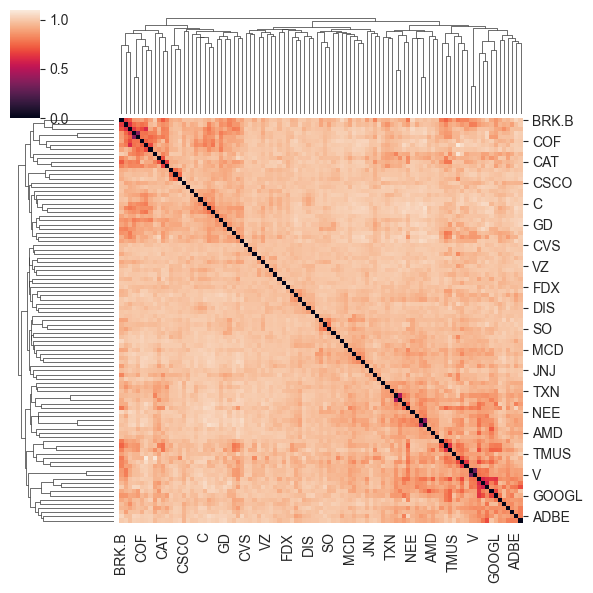

In [19]:
sns.clustermap(detoned_vi_distance, figsize = (6,6))

### Clustering (ONC Algorithm)

In [20]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.decomposition import PCA

def evaluate_k(
        k : int,
        linkage_matrix : np.ndarray,
        dist_matrix : np.ndarray,
    ) -> tuple:
    """
    Evaluates the clustering quality for a given k using the silhouette score.
    """
    # Assign cluster labels based on the linkage matrix for a specific k
    labels = fcluster(linkage_matrix, t=k, criterion='maxclust')

    # Handle cases where clustering fails to produce at least 2 clusters
    if len(np.unique(labels)) < 2:
        return k, -1

    # Calculate silhouette score using the precomputed distance matrix
    score = silhouette_score(
        dist_matrix,
        labels,
        metric='precomputed'
    )
    return k, score

def get_cluster_representatives(
    data: pd.DataFrame,
    mi_dist_df: pd.DataFrame,
    max_k: int = 10,
    n_jobs: int = -1
) -> tuple:
    """
    Performs Optimal Number of Clusters (ONC) search and extracts the
    first principal component (PC1) for each cluster.

    Args:
        data: Standardized/FracDiff time-series DataFrame (Assets as columns).
        mi_dist_df: Precomputed Mutual Information distance matrix.
        max_k: Maximum number of clusters to explore.
        n_jobs: Number of CPU cores for parallel processing (-1 uses all).

    Returns:
        pc1_df: DataFrame containing the PC1 time-series for each cluster.
        clusters: Series mapping each asset to its assigned cluster.
    """
    print(f"🚀 Starting ONC Algorithm: Parallel search from k=2 to {max_k} (n_jobs={n_jobs})")

    # Perform hierarchical clustering using the average linkage method
    dist_array = mi_dist_df.values
    linkage_matrix = linkage(dist_array, method='average')

    # Parallel search for the optimal k based on the silhouette score
    # Wrapped in list brackets [] to avoid SyntaxError in certain Python environments
    results = Parallel(n_jobs=n_jobs)(
        [delayed(evaluate_k)(k, linkage_matrix, dist_array) for k in tqdm(range(2, max_k + 1), desc="Progress of ONC Exploration")]
    )

    # Extract the k value with the highest silhouette score
    best_k, best_score = max(results, key=lambda x: x[1])
    print(f"Optimal number of clusters found: {best_k} (Best Silhouette Score: {best_score:.4f})")

    # Perform final clustering with the optimal k
    final_labels = fcluster(
        linkage_matrix,
        t = best_k,
        criterion = 'maxclust'
    )
    clusters = pd.Series(final_labels, index=data.columns)

    # Extract the First Principal Component (PC1) for each cluster node
    pc1_dict = {}
    for c in range(1, best_k + 1):
        assets_in_cluster = clusters[clusters == c].index
        cluster_data = data[assets_in_cluster]

        # Condense the cluster information into a single latent causal node via PCA
        pca = PCA(n_components=1)
        pc1_series = pca.fit_transform(cluster_data).flatten()
        pc1_dict[f'Cluster_{c}'] = pc1_series

    # Construct the final DataFrame for Causal Discovery (NOTEARS/DYNOTEARS)
    pc1_df = pd.DataFrame(pc1_dict, index=data.index)

    return (pc1_df, clusters)

In [21]:
def get_assets_by_cluster(cluster_mapping):
    cluster_dict = {}
    unique_clusters = sorted(cluster_mapping.unique())

    print(f"=== Result of asset clustering(number of groups : {len(unique_clusters)}) ===\n")

    for c in unique_clusters:
        assets = cluster_mapping[cluster_mapping == c].index.tolist()
        cluster_dict[f'Cluster_{c}'] = assets

        print(f"Cluster {c} (number of asset : {len(assets)}):")
        print(f"   {', '.join(assets)}")
        print("-" * 50)

    return cluster_dict

In [22]:
pc1_df, cluster_mapping = get_cluster_representatives(
    fracdiff_price.loc['2016':].dropna(axis = 1),
    detoned_vi_distance,
    max_k = 10,
    n_jobs = -2
)

🚀 Starting ONC Algorithm: Parallel search from k=2 to 10 (n_jobs=-2)


Progress of ONC Exploration: 100%|██████████| 9/9 [00:00<00:00, 166293.99it/s]


Optimal number of clusters found: 3 (Best Silhouette Score: 0.0427)


In [23]:
get_assets_by_cluster(cluster_mapping)

=== Result of asset clustering(number of groups : 3) ===

Cluster 1 (number of asset : 30):
   AIG, AXP, BAC, BK, BKNG, BLK, BRK.B, C, CAT, COF, COP, CSCO, CVX, DE, EMR, GD, GE, GILD, GM, GS, IBM, JPM, MET, MS, RTX, SCHW, SPG, USB, WFC, XOM
--------------------------------------------------
Cluster 2 (number of asset : 33):
   ABBV, AMGN, AMT, BA, BMY, CL, CMCSA, CVS, DIS, DUK, FDX, INTC, JNJ, KO, LMT, MCD, MDLZ, MDT, MMM, MO, MRK, NKE, PEP, PFE, PG, PM, SBUX, SO, T, TGT, UNH, UPS, VZ
--------------------------------------------------
Cluster 3 (number of asset : 34):
   AAPL, ABT, ACN, ADBE, AMD, AMZN, AVGO, COST, CRM, DHR, GOOGL, HD, HON, INTU, ISRG, LIN, LLY, LOW, MA, META, MSFT, NEE, NFLX, NOW, NVDA, ORCL, QCOM, TMO, TMUS, TSLA, TXN, UNP, V, WMT
--------------------------------------------------


{'Cluster_1': ['AIG',
  'AXP',
  'BAC',
  'BK',
  'BKNG',
  'BLK',
  'BRK.B',
  'C',
  'CAT',
  'COF',
  'COP',
  'CSCO',
  'CVX',
  'DE',
  'EMR',
  'GD',
  'GE',
  'GILD',
  'GM',
  'GS',
  'IBM',
  'JPM',
  'MET',
  'MS',
  'RTX',
  'SCHW',
  'SPG',
  'USB',
  'WFC',
  'XOM'],
 'Cluster_2': ['ABBV',
  'AMGN',
  'AMT',
  'BA',
  'BMY',
  'CL',
  'CMCSA',
  'CVS',
  'DIS',
  'DUK',
  'FDX',
  'INTC',
  'JNJ',
  'KO',
  'LMT',
  'MCD',
  'MDLZ',
  'MDT',
  'MMM',
  'MO',
  'MRK',
  'NKE',
  'PEP',
  'PFE',
  'PG',
  'PM',
  'SBUX',
  'SO',
  'T',
  'TGT',
  'UNH',
  'UPS',
  'VZ'],
 'Cluster_3': ['AAPL',
  'ABT',
  'ACN',
  'ADBE',
  'AMD',
  'AMZN',
  'AVGO',
  'COST',
  'CRM',
  'DHR',
  'GOOGL',
  'HD',
  'HON',
  'INTU',
  'ISRG',
  'LIN',
  'LLY',
  'LOW',
  'MA',
  'META',
  'MSFT',
  'NEE',
  'NFLX',
  'NOW',
  'NVDA',
  'ORCL',
  'QCOM',
  'TMO',
  'TMUS',
  'TSLA',
  'TXN',
  'UNP',
  'V',
  'WMT']}

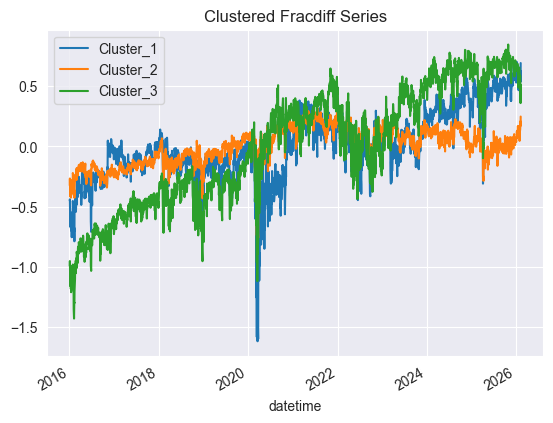

In [24]:
pc1_df.plot()
plt.title('Clustered Fracdiff Series')
plt.show()

### Macro Features

#### Inflation (Proxy : Breakeven Inflation)

In [25]:
tv = TvDatafeed()

bei = tv.get_hist(
    symbol = 'T10YIE',
    exchange = 'FRED',
    n_bars = 13000,
    interval = Interval.in_daily
)
bei.index = pd.to_datetime(
    bei.index.strftime('%Y-%m-%d'),
)

<Axes: xlabel='datetime'>

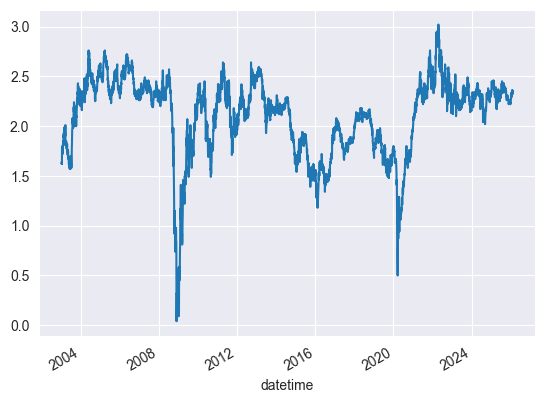

In [26]:
bei['close'].plot()

#### VIX

In [27]:
vix = tv.get_hist(
    symbol = 'VIX',
    exchange = 'TVC',
    n_bars = 13000,
    interval = Interval.in_daily
)
vix.index = pd.to_datetime(
    vix.index.strftime('%Y-%m-%d'),
)

<Axes: xlabel='datetime'>

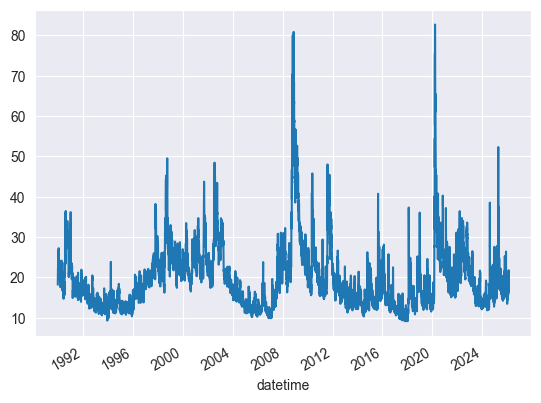

In [28]:
vix['close'].plot()

#### US OIL

In [29]:
oil = tv.get_hist(
    symbol = 'USOIL',
    exchange = 'TVC',
    n_bars = 10000,
    interval = Interval.in_daily
)
oil.index = pd.to_datetime(
    oil.index.strftime('%Y-%m-%d'),
)

<Axes: xlabel='datetime'>

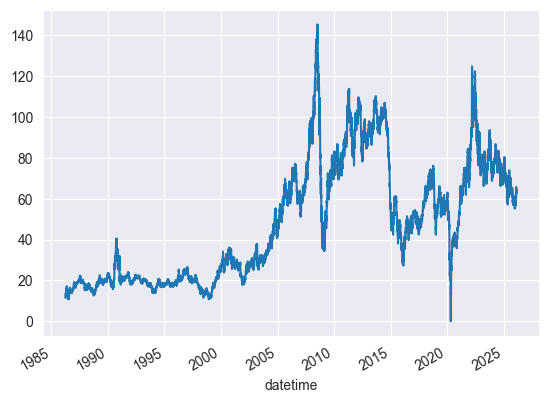

In [30]:
oil['close'].plot()

#### T Bill 3 Months

In [31]:
tbill = tv.get_hist(
    symbol = 'US03MY',
    exchange = 'TVC',
    n_bars = 13000,
    interval = Interval.in_daily
)
tbill.index = pd.to_datetime(
    tbill.index.strftime('%Y-%m-%d'),
)

<Axes: xlabel='datetime'>

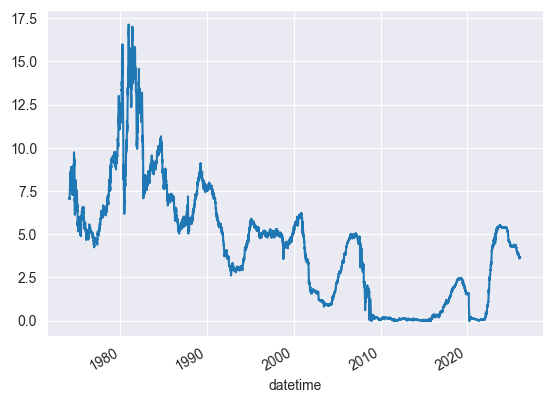

In [32]:
tbill['close'].plot()

#### Credit Risk (Proxy : High yield)

- delayed data (1 day)

In [33]:
high_yield = tv.get_hist(
    symbol = 'BAMLH0A0HYM2',
    exchange = 'FRED',
    n_bars = 13000,
    interval = Interval.in_daily
)
high_yield.index = pd.to_datetime(
    high_yield.index.strftime('%Y-%m-%d'),
)

<Axes: xlabel='datetime'>

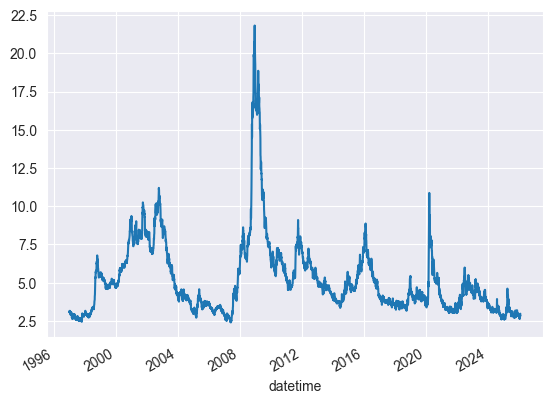

In [34]:
high_yield['close'].plot()

#### Manufacture Demands (Proxy - Copper Spot)

In [35]:
copper = tv.get_hist(
    symbol = 'COPPER',
    exchange = 'CAPITALCOM',
    n_bars = 13000,
    interval = Interval.in_daily
)
copper.index = pd.to_datetime(
    copper.index.strftime('%Y-%m-%d'),
)

<Axes: xlabel='datetime'>

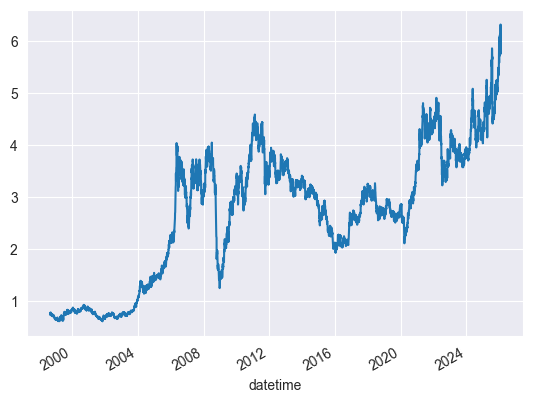

In [36]:
copper['close'].plot()

#### Dollar Index

In [39]:
dollar_index = tv.get_hist(
    symbol = 'DXY',
    exchange = 'TVC',
    n_bars = 13000,
    interval = Interval.in_daily
)
dollar_index.index = pd.to_datetime(
    dollar_index.index.strftime('%Y-%m-%d'),
)

<Axes: xlabel='datetime'>

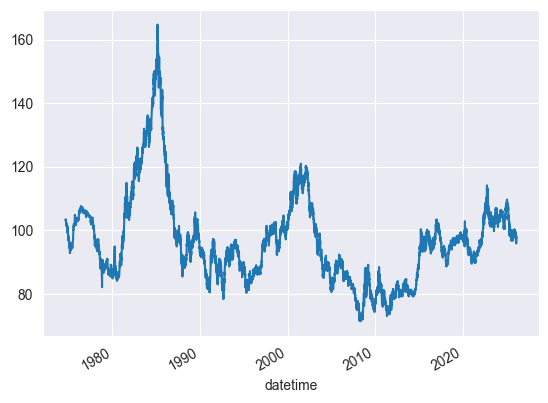

In [40]:
dollar_index['close'].plot()

In [41]:
high_yield_spread = high_yield['close'].shift(1) - tbill['close']

<Axes: xlabel='datetime'>

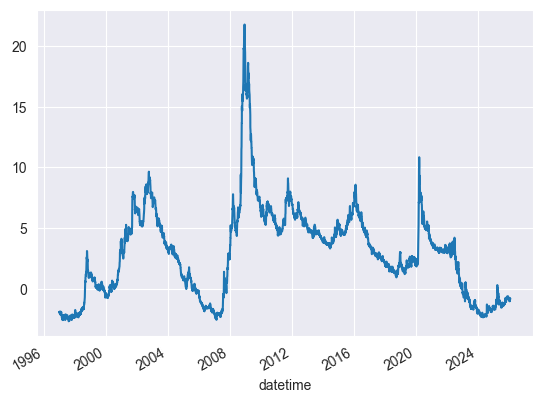

In [42]:
high_yield_spread.ffill().plot()

In [43]:
macro_factor = pd.concat(
    [
        bei['close'],
        vix['close'],
        np.log(oil['close']),
        tbill['close'],
        np.log(copper['close']),
        np.log(dollar_index['close']),
        high_yield_spread.ffill()
    ], axis = 1
).loc[prices.loc['1990':].index]

In [44]:
macro_factor.columns = ['BEI','VIX','USOIL','TBILL','COPPER','DXY','HYS']

In [45]:
# macro_representative_d, macro_all_ds = get_representative_d(
#     macro_factor[['USOIL','COPPER','DXY']],
#     quantile=0.95
# )

🔍 Searching for minimum stationarity 'd' per asset...
🎯 Representative d selected: 0.19 (Quantile: 0.95)


In [46]:
# fracdiff_macro = apply_uniform_frac_diff(
#     macro_factor[['USOIL','COPPER','DXY']],
#     0.2,
#     n_jobs = -2
# )

🚀 Applying uniform FracDiff (d=0.20) to all columns...


In [92]:
macro_features = pd.concat(
    [
        macro_factor[['BEI']],
        macro_factor[['VIX']].pct_change(),
        macro_factor[['TBILL','HYS']].diff(20),
        macro_factor[['COPPER','USOIL','DXY']].pct_change(252),
    ], axis = 1
)

In [93]:
macro_features = macro_features.loc['2015':].ffill() # final macro feature matrix

<Axes: xlabel='datetime'>

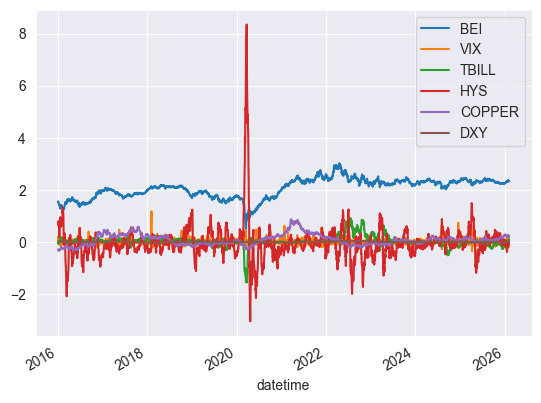

In [94]:
macro_features.loc['2016':].drop('USOIL', axis = 1).plot()

In [95]:
final_feature_matrix = pd.concat(
    [
        macro_features.loc['2016':],
        pc1_df
    ], axis = 1
)

In [96]:
final_feature_matrix.to_parquet('../data/feature_matrix.parquet')
prices.to_parquet('../data/prices.parquet')